In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
from keras.models import Sequential

In [118]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

def create_timeframe(X, y, t, k):
    time_data = X[t - k: t]
    time_targ = y[t - k: t]
    vali_data = X[t + 1: train_split]
    vali_targ = y[t + 1: train_split]
    return time_data, time_targ, vali_data, vali_targ

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [2]:
df = pd.read_csv("../data/daily-min-temperatures.csv")

In [3]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


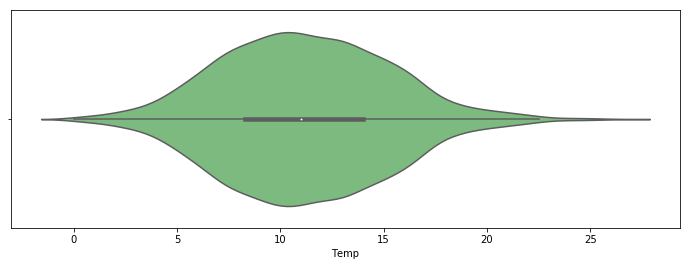

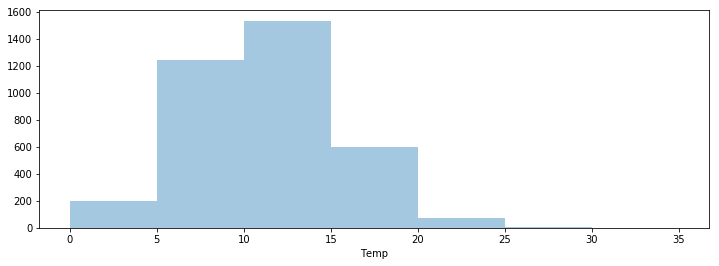

In [176]:
plt.figure(figsize=(12, 4))
sns.violinplot(x=df['Temp'], palette="Greens")
plt.figure(figsize=(12, 4))
sns.distplot(df['Temp'],bins=[i for i in range(0,40,5)], kde=False)

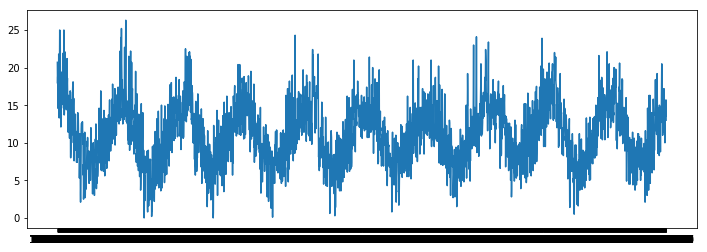

In [85]:
plt.figure(figsize=(12, 4))
plt.plot(df['Temp'])

In [153]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))

learning_rate = 0.001
epochs = 10
t, k = 2200, 1200
# reshape into X=t and Y=t+1
look_back = 1
#Create dataset creates targets as next entries value
train, test = df["Temp"].iloc[0:train_split], df["Temp"].iloc[train_split:]
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
#LSTM only accepts 3D inputs, increase dimensionality
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
#Create the timeframe w.r.t t and k values
X_train, y_train, X_val, y_val = create_timeframe(X_train, y_train, t, k)

In [154]:
#Number of training examples in timeframe is equal to k
#Number of validation examples is equal to training set size - t
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(1200, 1, 1)
(1200,)
(728, 1, 1)
(728,)
(717, 1, 1)
(717,)


In [157]:
# create and fit LSTM model
model = Sequential()
model.add(keras.layers.LSTM(32))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [159]:
h = model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2, validation_data=(X_val, y_val), callbacks=[es_callback, modelckpt_callback])

Train on 1200 samples, validate on 717 samples
Epoch 1/200
 - 2s - loss: 42.3622 - val_loss: 9.5685

Epoch 00001: val_loss improved from inf to 9.56846, saving model to model_checkpoint.h5
Epoch 2/200
 - 1s - loss: 8.1548 - val_loss: 7.5449

Epoch 00002: val_loss improved from 9.56846 to 7.54488, saving model to model_checkpoint.h5
Epoch 3/200
 - 1s - loss: 7.2746 - val_loss: 7.1767

Epoch 00003: val_loss improved from 7.54488 to 7.17668, saving model to model_checkpoint.h5
Epoch 4/200
 - 1s - loss: 7.0635 - val_loss: 6.9748

Epoch 00004: val_loss improved from 7.17668 to 6.97475, saving model to model_checkpoint.h5
Epoch 5/200
 - 1s - loss: 6.9718 - val_loss: 6.8911

Epoch 00005: val_loss improved from 6.97475 to 6.89111, saving model to model_checkpoint.h5
Epoch 6/200
 - 1s - loss: 6.9337 - val_loss: 6.9001

Epoch 00006: val_loss did not improve from 6.89111
Epoch 7/200
 - 1s - loss: 6.8546 - val_loss: 7.1963

Epoch 00007: val_loss did not improve from 6.89111
Epoch 8/200
 - 1s - los

In [163]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [164]:
import math
# Estimate model performance
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 6.80 MSE (2.61 RMSE)
Test Score: 6.35 MSE (2.52 RMSE)


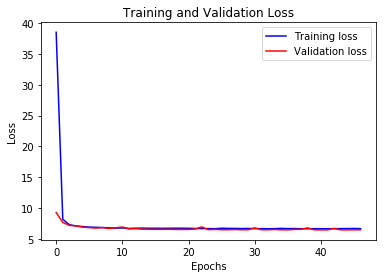

In [146]:
visualize_loss(h, "Training and Validation Loss")